# testing the cell type token fine tuned model, test the evals class

In [3]:
print('eQTL on one model', flush=True)
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import argparse
from src.dataloaders.datasets.general_dataset import GeneralDataset
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import JointCNNWithCTT
from caduceus.configuration_caduceus import CaduceusConfig
import yaml
from omegaconf import OmegaConf
import os
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr
from torch.utils.data import DataLoader
import pickle

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                #  data_idxs=None, #the actual value in the full self.dataset.data (so for GM12878 it's 12 or 69). Lets you access a new celltype or just subset to a smaller set of celltypes
                #  sequences_bed_file=None,
                 ) -> None:
        #TODO make it so that we can take in arbitrary dataset information in like a dict and adds options to dataset
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # if data_idxs is not None:
            #     dataset_args['data_idxs'] = data_idxs
            # if sequences_bed_file is not None:
            #     dataset_args['sequences_bed_file'] = sequences_bed_file
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = EnformerDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.cfg['encoder']['celltypes'] = 7 #hardcoding for now because it becomes 1 when we use the npz file
        self.encoder = JointCNNWithCTT(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None, softplus=True, og=False, ctt_val=0):
        #now evaluate the model on one example
        if data is None:
            (seq,acc,ctt),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            ctt = ctt.unsqueeze(0)
        else:
            x,y,ctt,seq_unmask,acc_unmask = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
                ctt = ctt.unsqueeze(0)
        
        if ctt_val is not None:
            ctt = torch.ones_like(ctt) * ctt_val
        
        x,y = x.to(self.device), y.to(self.device)
        ctt = ctt.to(self.device)
        
        with torch.no_grad():
            # print(x.shape, y.shape, ctt.shape)
            # print(ctt) #is indeed 6
            x1 = self.encoder(x,y,ctt)
            # print(torch.allclose(x1[0,:,0], self.encoder.ctt_embedding(ctt))) #is indeed true!!
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
            
        return x1
    


eQTL on one model


In [7]:
__name__

'__main__'

In [6]:
def main(args):
    ckpt_path = args.ckpt_path
    evals = Evals(ckpt_path,load_data=args.load_data, data_idxs=args.data_idxs, data_path=args.data_path, additional_data=None, additional_data_idxs=None) #we don't need it to load expression data, force it not to

    mapping = {
        'A': torch.tensor([1, 0, 0, 0], dtype=torch.float32),
        'C': torch.tensor([0, 1, 0, 0], dtype=torch.float32),
        'G': torch.tensor([0, 0, 1, 0], dtype=torch.float32),
        'T': torch.tensor([0, 0, 0, 1], dtype=torch.float32),
        'N': torch.tensor([0, 0, 0, 0], dtype=torch.float32),
    }
    
    #should just use the actual data ideally but manually loading it in is easier, doesn't work if you use the zarr file

    onehot_mapping = {0:'A',1:'C',2:'G',3:'T'}

    qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
    qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']

    length = 524288

    output_array = np.zeros((qtls.shape[0],896,2))
    
    base_dir = '/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/'
    with open(base_dir+'genes.pickle', 'rb') as f:
        gene_annotation = pickle.load(f)
    ordered_genes = sorted(list(gene_annotation.keys()))
    tmpgeneTSS = np.loadtxt(base_dir+'ensemblTSS.txt', dtype='str')
    geneTSS_dic = {tmpgeneTSS[i, 0]: int(tmpgeneTSS[i, 1]) for i in range(tmpgeneTSS.shape[0])}
    

    for i in tqdm(range(qtls.shape[0])):
        temp = qtls.iloc[i]
        chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
        pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
        gene_idx= temp['gene_idx']
        tss_loc = geneTSS_dic[ordered_genes[gene_idx]]
        
        start = tss_loc - length//2
        end = tss_loc + length//2

        #let's get eqtl position
        eQTL_pos = pos - start
        if 0 <= eQTL_pos < length:
            2
        else:
            continue
        
        idx = evals.dataset.expand_seqs(chrom,start,end)
        # data = evals.dataset[idx]
        
        ((s,a),(su,au)) = evals.dataset[idx]
        # data = ((s,a), (None, None)) #we don't need theunmasked as we will just put it into the model normally
        # data = (None,None,su,au) #can be s and a or None, it isn't used by the mask function
        #now we add a batch dimension to s and a, and double the values
        s = s.unsqueeze(0).repeat(2, 1, 1) #now is 1 x 6 x 524288
        a = a.unsqueeze(0).repeat(2, 1, 1)
        #now we can edit the input sequence
        current_nuc = s[0, :, eQTL_pos].cpu().numpy()
        current_nuc = np.argmax(current_nuc)
        current_nuc = onehot_mapping[current_nuc]

        assert current_nuc == temp['ref'], f'current nuc {current_nuc} does not match ref {temp["ref"]} for {temp["label"]}'

        s[1, :4, eQTL_pos] = mapping[temp['alt']]
        data = ((s,a),(None,None))
        
        out = evals(data = data)
        
        output_array[i,:,:] = out[:,:,0].cpu().numpy().T
        

    np.save(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{args.output}', output_array)
    if args.verbose:
        print(f'saved dsQTL results to {args.output}')
        # print(f'loaded checkpoint from {args.ckpt_path}')
        print('dsQTL run complete')
    
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='run dsQTL on one model')
    parser.add_argument('--ckpt_path', type=str, default='/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt', help='Path to the checkpoint')
    parser.add_argument('-o', '--output', type=str, default='output_test.npy', help='Output file path')
    parser.add_argument('-v', '--verbose', action='store_false', help='Disable verbose output')
    parser.add_argument('--data_idxs', nargs='+',type=int,help='List of mask sizes', default=None) #intentionally passes None as a default, tells it to not find any data idxs
    parser.add_argument('--load_data', action='store_true', help='Load data from the checkpoint')
    parser.add_argument('--data_path', type=str, default='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz', help='Path to the data')
    args = parser.parse_args()
    
    print(args)
    if args.verbose:
        # print(f'args: {args}')
        print(f'running eQTL on model and saving results to {args.output}')
        print(f'loading checkpoint from {args.ckpt_path}')
    
    main(args)
    # ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-31-41-192495/checkpoints/last.ckpt' #for the generalizing model

usage: ipykernel_launcher.py [-h] [--ckpt_path CKPT_PATH] [-o OUTPUT] [-v]
                             [--data_idxs DATA_IDXS [DATA_IDXS ...]]
                             [--load_data] [--data_path DATA_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/tiwaris2/.local/share/jupyter/runtime/kernel-bde5474c-3540-413f-9eed-805de5a50750.json


SystemExit: 2

# we reddid the cellt ype token, let's see if the results are similar

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_3450275/3692982124.py:108: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


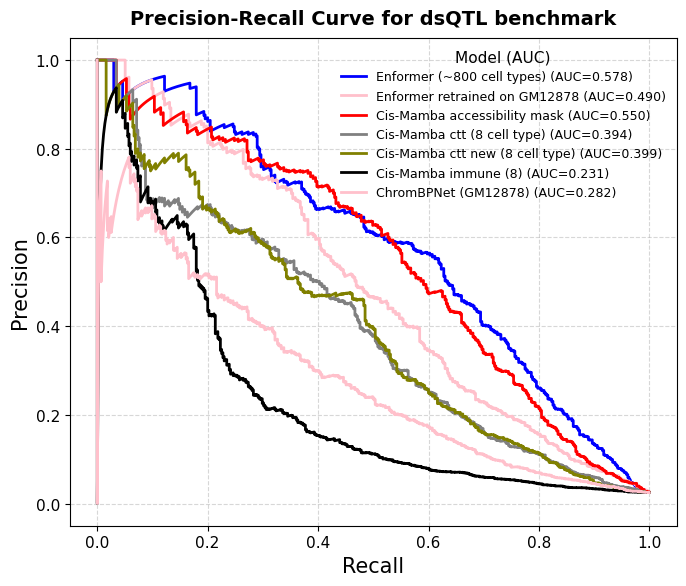

In [1]:
#load in the npy files and test it

#now let's look at dsqtl results, then we will look at different regions and see if it is predicting larger differences between cell types

# ok this will be slightly annoying...

#we will include the major models, we will not add in alpha genome. 

#let's go ahead and make this one with the dsQTL results


#want to use the same models that we trained with eQTL

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt


def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2



qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
    
def softmax(x, temp=1):
    norm_x = x - np.mean(x, axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

def predict_snp_effect_scores_bpnet(ref_prob_preds, alt_prob_preds, ref_count_preds, alt_count_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    
    print(ref_prob_preds.shape, alt_prob_preds.shape, ref_count_preds.shape, alt_count_preds.shape)
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    #and account for nan
    log_probs_diff_abs_sum[np.isnan(log_probs_diff_abs_sum)] = 0
    # probs_jsd_diff = np.array([jensenshannon(softmax(x),softmax(y)) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    probs_jsd_diff = np.squeeze([jensenshannon(x, y, base=2.0)
                     for x,y in zip(softmax(alt_prob_preds),
                                    softmax(ref_prob_preds))])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_count_preds/alt_count_preds)[:,0]
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2
    
labels = qtls['label'].to_numpy()

#A slightly different version where we don't use mamba 8 cell types but isntead use Enformer on 1 cell type

#make it look better
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=False, titles=None, title=None):
    """
    Plots publication-ready Precision-Recall curves for selected SNP effect metrics.
    """
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    # Set up the figure
    plt.figure(figsize=(7, 6))
    plt.rcParams.update({'font.size': 11})

    # Color cycle and line style
    # color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    line_width = 2

    colors = ['blue', 'pink', 'red', 'gray', 'olive', 'black', 'pink', 'gray', 'olive', 'cyan']

    legend_entries = []

    # Plot each model's PR curve
    for i, file in enumerate(files):
        if file.endswith('.npz'):
            pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
            out = predict_snp_effect_scores_bpnet(
                pred_cbp['profile'][:, :, 0],
                pred_cbp['profile'][:, :, 1],
                pred_cbp['counts'][:, :, 0],
                pred_cbp['counts'][:, :, 1]
            )
        else:
            eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            if enformer_center and 'enformer' in file:
                eqtl_data = eqtl_data[:, 440:456, :]
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        scores = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], scores)
        pr_auc = auc(recall, precision)

        line, = plt.plot(
            recall,
            precision,
            label=titles[i] if titles else file,
            color=colors[i],
            linewidth=line_width
        )
        legend_entries.append((pr_auc, line, f"{titles[i]} (AUC={pr_auc:.3f})"))

    # Format title and labels
    plt.title(
        title or f'Precision–Recall Curve ({metric_name.upper()})',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)

    # Grid for readability
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Sort legend by AUC if requested
    if sort_legend_by_auc:
        legend_entries.sort(key=lambda x: x[0], reverse=True)
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    # Legend styling
    plt.legend(
        handles,
        labels_sorted,
        title='Model (AUC)',
        title_fontsize=11,
        fontsize=9,
        loc='upper right',
        frameon=False
    )

    # Tight layout and display
    plt.tight_layout()
    plt.show()

files = ['enformer_dsqtl.npy', 'enformer_dsqtl_retrained-dsqtl.npy', 'nomlm_maskonly.npy', 'ctt_legacy.npy', 'ctt_new.npy', 'immune_all_2.npy', '.npz']
titles = ['Enformer (~800 cell types)', 'Enformer retrained on GM12878', 'Cis-Mamba accessibility mask', 'Cis-Mamba ctt (8 cell type)', 'Cis-Mamba ctt new (8 cell type)', 'Cis-Mamba immune (8)',
                     'ChromBPNet (GM12878)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

In [ ]:
#yeah so basically no difference which is exactly what we're hoping for!! shows both consistent retraining and that the new approach is identical
#so let's stick to this new approach going forward